In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

import joblib
from sklearn.pipeline import Pipeline

In [9]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
negaciones = {'no', 'nunca', 'jamás', 'sin'}
stop_words = stop_words - negaciones


In [13]:
datos = pd.read_csv('/content/dataset_sentimientos_robusto.csv')

#Exploración de datos

In [14]:
datos.head()

,id,texto,sentimiento,categoria,fecha,dia_semana,hora_aproximada,es_fin_de_semana,calificacion,canal,...,num_palabras,tiene_mayusculas_excesivas,num_signos_exclamacion,tiempo_respuesta_horas,fue_respondido,resolucion,prioridad,requiere_atencion_inmediata,confianza_modelo,requiere_revision_humana
0,1,Es aceptable,Neutro,Soporte Técnico,2024-12-09,Monday,Noche,False,3,Teléfono,...,2,False,0,36.0,True,NaN,Media,False,0.76,True
1,2,Es adecuado. Servicio regular,Neutro,Delivery,2025-08-03,Sunday,Tarde,True,3,Email,...,4,False,0,55.0,True,Resuelto,Baja,False,0.64,True
2,3,El servicio fue malísimo!,Negativo,Delivery,2024-02-04,Sunday,Noche,True,1,App Móvil,...,4,False,1,NaN,False,NaN,Media,False,0.81,False
3,4,Entrega rápida y producto impecable. Servicio ...,Positivo,Aplicación Móvil,2025-11-15,Saturday,Mañana,True,5,Email,...,9,False,1,NaN,False,NaN,Baja,False,0.85,False
4,5,No lo recomiendo para nada,Negativo,Hotel,2024-09-26,Thursday,Noche,False,1,Chat,...,5,False,0,NaN,False,NaN,Media,False,0.94,False


In [15]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           15000 non-null  int64  
 1   texto                        15000 non-null  object 
 2   sentimiento                  15000 non-null  object 
 3   categoria                    15000 non-null  object 
 4   fecha                        15000 non-null  object 
 5   dia_semana                   15000 non-null  object 
 6   hora_aproximada              15000 non-null  object 
 7   es_fin_de_semana             15000 non-null  bool   
 8   calificacion                 15000 non-null  int64  
 9   canal                        15000 non-null  object 
 10  precio_rango                 15000 non-null  object 
 11  tiempo_desde_compra_dias     15000 non-null  int64  
 12  tema_principal               15000 non-null  object 
 13  longitud_caracte

In [16]:
datos.describe()

,id,calificacion,tiempo_desde_compra_dias,longitud_caracteres,num_palabras,num_signos_exclamacion,tiempo_respuesta_horas,confianza_modelo
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,9629.000000,15000.000000
mean,7500.500000,3.195267,50.048533,35.214067,5.291133,0.239000,37.060339,0.832238
std,4330.271354,1.382099,29.767800,16.276520,2.488129,0.510976,27.341612,0.091511
min,1.000000,1.000000,1.000000,7.000000,2.000000,0.000000,1.000000,0.600000
25%,3750.750000,2.000000,25.000000,23.000000,4.000000,0.000000,17.000000,0.770000
50%,7500.500000,3.000000,49.000000,30.000000,5.000000,0.000000,32.000000,0.840000
75%,11250.250000,4.000000,73.000000,49.000000,7.000000,0.000000,48.000000,0.900000
max,15000.000000,5.000000,120.000000,84.000000,15.000000,2.000000,120.000000,0.990000


In [17]:
datos[['tiempo_respuesta_horas', 'resolucion']].isnull().sum()
datos[['tiempo_respuesta_horas', 'resolucion']].isnull().mean()


,0
tiempo_respuesta_horas,0.358067
resolucion,0.585067


In [18]:
datos['resolucion'] = datos['resolucion'].map({
    'Resuelto': 1,
    'En Proceso': 0
})


In [19]:
datos['resolucion'].fillna(-1, inplace=True)


/tmp/ipython-input-1539846462.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['resolucion'].fillna(-1, inplace=True)


In [20]:
datos['tiempo_respuesta_horas'].fillna(
    datos['tiempo_respuesta_horas'].median(),
    inplace=True
)

datos['resolucion'].fillna(
    datos['resolucion'].median(),
    inplace=True
)


/tmp/ipython-input-2894709236.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['tiempo_respuesta_horas'].fillna(
/tmp/ipython-input-2894709236.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [21]:
datos['resolucion'].fillna(-1, inplace=True)

/tmp/ipython-input-2288008937.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['resolucion'].fillna(-1, inplace=True)


In [22]:
check_nan = datos.isna().any()
print(check_nan)

id                             False
texto                          False
sentimiento                    False
categoria                      False
fecha                          False
dia_semana                     False
hora_aproximada                False
es_fin_de_semana               False
calificacion                   False
canal                          False
precio_rango                   False
tiempo_desde_compra_dias       False
tema_principal                 False
longitud_caracteres            False
num_palabras                   False
tiene_mayusculas_excesivas     False
num_signos_exclamacion         False
tiempo_respuesta_horas         False
fue_respondido                 False
resolucion                     False
prioridad                      False
requiere_atencion_inmediata    False
confianza_modelo               False
requiere_revision_humana       False
dtype: bool


#Variable objetivo

In [23]:
datos['sentimiento'].value_counts()


,count
sentimiento,
Positivo,6750
Negativo,4500
Neutro,3750


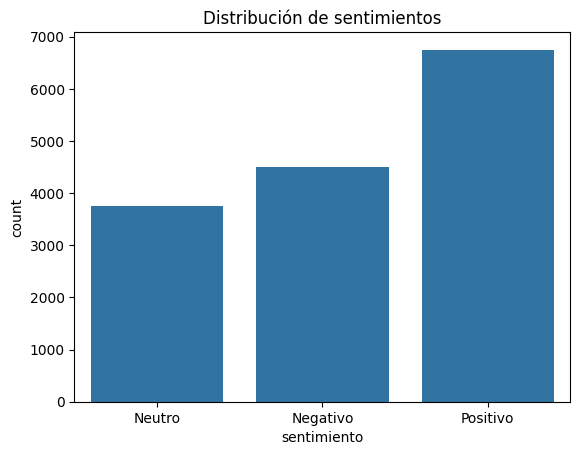

In [24]:
sns.countplot(data=datos, x='sentimiento')
plt.title("Distribución de sentimientos")
plt.show()


#Limpieza y procesamiento de texto

In [25]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'\d+', ' NUM ', texto)
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    texto = texto.strip()

    texto = ' '.join(
        palabra for palabra in texto.split()
        if palabra not in stop_words
    )
    return texto


In [26]:
datos['texto_limpio'] = datos['texto'].apply(limpiar_texto)
datos[['texto', 'texto_limpio']].head()


,texto,texto_limpio
0,Es aceptable,aceptable
1,Es adecuado. Servicio regular,adecuado servicio regular
2,El servicio fue malísimo!,servicio malísimo
3,Entrega rápida y producto impecable. Servicio ...,entrega rápida producto impecable servicio NUM...
4,No lo recomiendo para nada,no recomiendo


#Definir X y Y

In [27]:
X = datos['texto_limpio']
y = datos['sentimiento']

#Vectorización con TF_IDF

In [28]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(X)


#Entrenamiento y prueba

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


#Entrenamiento del modelo

In [30]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#Predicciones

In [33]:
y_pred = modelo.predict(X_test)
print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred))
print("Precisión:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))


Exactitud (Accuracy): 0.9956666666666667
Precisión: 0.9957079970652971
Recall: 0.9956666666666667
F1-score: 0.9956581068362224


In [35]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negativo       1.00      1.00      1.00       900
      Neutro       1.00      0.98      0.99       750
    Positivo       0.99      1.00      1.00      1350

    accuracy                           1.00      3000
   macro avg       1.00      0.99      1.00      3000
weighted avg       1.00      1.00      1.00      3000



#Serialización del modelo

In [36]:
joblib.dump(modelo, "modelo_sentimientos.pkl")
joblib.dump(tfidf, "tfidf_vectorizador.pkl")


['tfidf_vectorizador.pkl']

In [37]:
modelo = joblib.load("modelo_sentimientos.pkl")
tfidf = joblib.load("tfidf_vectorizador.pkl")


#Pipeline Completo

In [39]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('modelo', LogisticRegression(max_iter=1000))
])

pipeline.fit(datos['texto'], y)
joblib.dump(pipeline, "pipeline_sentimientos.pkl")


['pipeline_sentimientos.pkl']